# DAE - Denoising Auto Encoder

In [3]:
# https://towardsdatascience.com/denoising-autoencoders-dae-how-to-use-neural-networks-to-clean-up-your-data-cd9c19bc6915
import torch
import torchvision
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
cpu_count = os.cpu_count()
mnist_data = torchvision.datasets.MNIST('./data/', download=True, transform = torchvision.transforms.ToTensor())
data_loader = torch.utils.data.DataLoader(mnist_data,
                                          batch_size=16,
                                          shuffle=True,
                                          num_workers=cpu_count,
                                          )

In [59]:
from PIL import Image 
img, label = mnist_data[33]
# img = img.permute(1,2,0)
torchvision.transforms.functional.to_pil_image(img, mode=None)


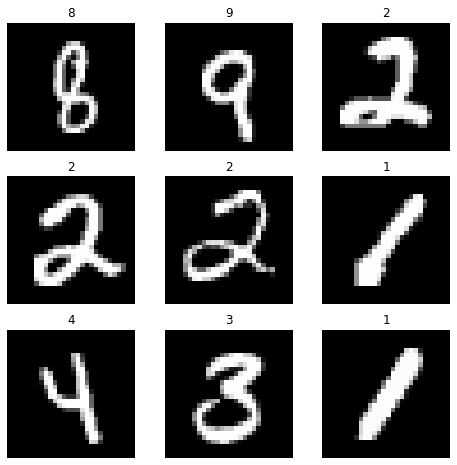

In [33]:
# Get image through dataset class
from PIL import Image 
# img, label = mnist_data[123]
# single_img = Image.Image(np.asarray(img)).show()

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_data), size=(1,)).item()
    img, label = mnist_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray") # squeeze is needed otherwise we will get error / 
                                           # TypeError: Image.__init__() takes 1 positional argument but 2 were given
plt.show()


Feature batch shape: torch.Size([16, 1, 28, 28])
Labels batch shape: torch.Size([16])


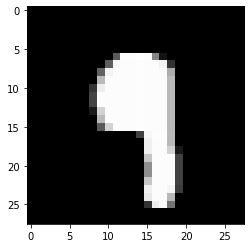

Label: 9


In [19]:
train_features, train_labels = next(iter(data_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

# examples = next(iter(data_loader))
# for label, img  in enumerate(examples):
#    plt.imshow(img.permute(1,2,0,3))
#    plt.show()
#    print(f"Label: {label}")


